# 8.9 Assignment: Support Vector Machine SVM

This assignment utilizes the data found here: https://users.stat.ufl.edu/~winner/data/armada.dat that contains outcomes of naval battels between Portuguese and Dutch/British ships between 1583 and 1663.

## TABLE OF CONTENTS:
[Data processing & exploration](#Data-processing-&-exploration)

[SVM application](#SVM-application)

[Random Forest application](#Random-forest-application)

[KNN application](#KNN-application)

[Results](#Results)

### Objectives:
1. Apply SVM-based model to predict the Portuguese outcome in battle by the number of ships involved on all sides as well as Spanish involvement
2. Apply 2 other classifiers to the dataset for the same predictive goal.

# Data processing & exploration

### Features in the data:
- battle_location: Name of the battle place

- year: Year of the battle

- portuguese_ships: Number of Portuguese ships

- dutch_ships: ships	Number of Dutch ships

- english_ships: Number of ships from English side

- portuguese_to_dutchbrit: The ratio of Portuguese to Dutch/British ships:	

- spain_involved: Spanish Involvement 1=Yes, 0=No

- portuguese_outcome: Portuguese outcome -1=Defeat, 0=Draw, 1=Victory

In [26]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#set column names
col_names = ['battle_location', 'year', 'portuguese_ships', 'dutch_ships', 'english_ships', 
              'portuguese_to_dutchbrit', 'spain_involved', 'portuguese_outcome']

#set column widths per txt file
col_widths = [30, 4, 8, 8, 8, 8, 8, 8]

#load data
data = pd.read_fwf('armada.dat.txt', header = None, names = col_names, widths = col_widths)
data.head()

,battle_location,year,portuguese_ships,dutch_ships,english_ships,portuguese_to_dutchbrit,spain_involved,portuguese_outcome
0,Bantam,1601,6,3,0,2.000,0,0
1,Malacca Strait,1606,14,11,0,1.273,0,0
2,Ilha das Naus,1606,6,9,0,0.667,0,-1
3,Pulo Butum,1606,7,9,0,0.778,0,1
4,Surrat,1615,6,0,4,1.500,0,0


In [3]:
#examine amount of data
data.shape

(28, 8)

In [4]:
#check for NA's
data.isna().sum().sum()

0

In [5]:
#check data types
data.dtypes

battle_location             object
year                         int64
portuguese_ships             int64
dutch_ships                  int64
english_ships                int64
portuguese_to_dutchbrit    float64
spain_involved               int64
portuguese_outcome           int64
dtype: object

In [6]:
#inspect distributions
data.describe()

,year,portuguese_ships,dutch_ships,english_ships,portuguese_to_dutchbrit,spain_involved,portuguese_outcome
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,1628.392857,13.142857,13.428571,1.785714,1.159893,0.464286,-0.178571
std,17.559084,15.922763,22.280083,5.927695,0.928341,0.507875,0.722832
min,1588.000000,2.000000,0.000000,0.000000,0.150000,0.000000,-1.000000
25%,1618.750000,5.750000,4.000000,0.000000,0.650250,0.000000,-1.000000
50%,1628.500000,6.000000,8.000000,0.000000,0.928500,0.000000,0.000000
75%,1639.000000,14.000000,11.000000,0.000000,1.500000,1.000000,0.000000
max,1658.000000,69.000000,110.000000,31.000000,4.636000,1.000000,1.000000


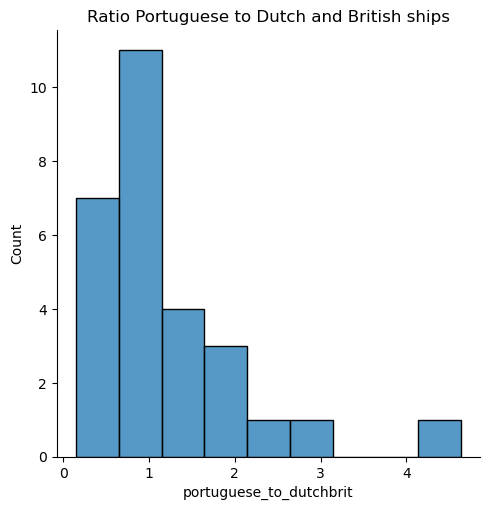

In [7]:
sns.displot(data, x = 'portuguese_to_dutchbrit')
plt.title('Ratio Portuguese to Dutch and British ships')
plt.show()

In [8]:
#examine instances where there were no dutch ships
data.loc[data['dutch_ships'] == 0]

,battle_location,year,portuguese_ships,dutch_ships,english_ships,portuguese_to_dutchbrit,spain_involved,portuguese_outcome
4,Surrat,1615,6,0,4,1.500,0,0
6,Jask,1620,4,0,4,1.000,0,0
7,Hormuz,1622,6,0,5,1.200,0,-1
15,Invincible Armada,1588,69,0,31,2.226,1,-1


In [9]:
#group outcomes by win/loss/neutral
data['portuguese_outcome'].value_counts()

 0    13
-1    10
 1     5
Name: portuguese_outcome, dtype: int64

In [10]:
#group outcomes by spanish involvement
data['spain_involved'].value_counts()

0    15
1    13
Name: spain_involved, dtype: int64

In [1]:
#sns.displot(data, x = 'english_ships')

In [2]:
#sns.displot(data, x = 'portuguese_ships')

In [3]:
#sns.displot(data, x = 'dutch_ships')

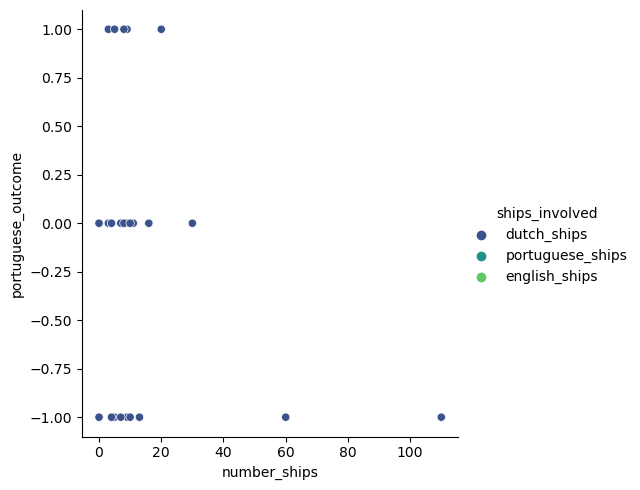

In [14]:
#visualize outcome and ships involved

#set x columns
x_cols = ['dutch_ships', 'portuguese_ships', 'english_ships']

#melt data into one column
melt_data = data.melt(value_vars = x_cols, var_name = 'ships_involved', value_name = 'number_ships')

#set y column
y_col = data['portuguese_outcome']

sns.relplot(data = melt_data, x='number_ships', y=y_col, hue='ships_involved', palette='viridis')
plt.show()

# SVM application

Goal: predict the Portuguese outcome in battle by the number of ships involved on all sides as well as Spanish involvement

In [15]:
#set features
X = data[['dutch_ships', 'portuguese_ships', 'english_ships', 'spain_involved']]
y = data['portuguese_outcome']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 11)

#initialize model
svm = SVC()

#set parameter values to optimize over
parameter_grid = {'C': [1, 5, 10, 20], 'kernel': ['linear', 'rbf', 'poly']}

#perform cross-validation with gridsearch
crossval = KFold(n_splits = 4, shuffle = True, random_state = 22)
param_optimization = GridSearchCV(estimator=svm, param_grid=parameter_grid, cv=crossval, scoring = 'accuracy')
param_optimization.fit(X_train, y_train)

#store best parameters
best_params = param_optimization.best_params_

#select model with best parameters, unpack the dictionary of best params
optimized_model = SVC(**best_params)
optimized_model.fit(X_train, y_train)
#make predictions
y_pred = optimized_model.predict(X_test)

#evaluate performance
svm_1_accuracy_score = accuracy_score(y_test, y_pred)

In [17]:
svm_1_accuracy_score

0.16666666666666666

## Scaling features

In [18]:
#standardize values
standard_scaler = StandardScaler()

#transform values
X_scaled = standard_scaler.fit_transform(X)

In [19]:
#redo model
X = X_scaled
y = y

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 11)

#initialize model
svm = SVC()

#set parameter values to optimize over
parameter_grid = {'C': [1, 5, 10, 20], 'kernel': ['linear', 'rbf', 'poly']}

#perform cross-validation with gridsearch
crossval = KFold(n_splits = 4, shuffle = True, random_state = 22)
param_optimization = GridSearchCV(estimator=svm, param_grid=parameter_grid, cv=crossval, scoring = 'accuracy')
param_optimization.fit(X_train, y_train)

#store best parameters
best_params = param_optimization.best_params_

#select model with best parameters, unpack the dictionary of best params
optimized_model = SVC(**best_params)
optimized_model.fit(X_train, y_train)
#make predictions
y_pred = optimized_model.predict(X_test)

#evaluate performance
svm2_accuracy_score = accuracy_score(y_test, y_pred)

In [20]:
svm2_accuracy_score

0.6666666666666666

# Random forest application



In [23]:
#initialize random forest
rand_forest = RandomForestClassifier()

#set features from model above
X = X
y = y

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 11)

#set parameter values to optimize over
parameter_grid = {'n_estimators': [10, 50, 100, 200], 'min_samples_split': [2, 4, 6]}

#perform cross-validation with gridsearch
crossval = KFold(n_splits = 4, shuffle = True, random_state = 22)
param_optimization = GridSearchCV(estimator=rand_forest, param_grid=parameter_grid, cv=crossval, scoring = 'accuracy')
param_optimization.fit(X_train, y_train)

#store best parameters
best_params = param_optimization.best_params_

#select model with best parameters, unpack the dictionary of best params
optimized_model = RandomForestClassifier(**best_params)
optimized_model.fit(X_train, y_train)
#make predictions
y_pred = optimized_model.predict(X_test)

#evaluate performance
rand_forest_accuracy_score = accuracy_score(y_test, y_pred)
rand_forest_accuracy_score

0.5

# KNN application

In [28]:
#initialize NB
knn = KNeighborsClassifier()

#set features from model above
X = X
y = y

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 11)

#set parameter values to optimize over
parameter_grid = {'n_neighbors': [3, 5, 7, 9]}

#perform cross-validation with gridsearch
crossval = KFold(n_splits = 4, shuffle = True, random_state = 22)
param_optimization = GridSearchCV(estimator=knn, param_grid=parameter_grid, cv=crossval, scoring = 'accuracy')
param_optimization.fit(X_train, y_train)

#store best parameters
best_params = param_optimization.best_params_

#select model with best parameters, unpack the dictionary of best params
optimized_model = KNeighborsClassifier(**best_params)
optimized_model.fit(X_train, y_train)
#make predictions
y_pred = optimized_model.predict(X_test)

#evaluate performance
knn_accuracy_score = accuracy_score(y_test, y_pred)
knn_accuracy_score

0.3333333333333333

# Results

My first SVM model performed poorly, only about 16.7% of its predictions on the test data were accurate. Since SVM is a rather complex algorithm, and the dataset only had 28 rows of vectors to work with, my intial thoughts were the model was not suitable for this type of data. At first I thought the ordinal relationship of the target variable might have skewed the model's performance, but found that SVM inherently handles multiclass, and ordinal categories well and doesn't necessarily require one-hot encoding. 
Therefore, considering my findings from the EDA stage, since there were instances in which there were no Spanish, British and even Portuguese ships involved in some of these battles, there were outlier values that could affect the model's performance due to its inherent sensitivity to the support vector's distances. So, I decided to redo my model a second time and standardize my values to measure the improvement. 
After standardizing the values to reduce the support vectors' influence on the hyperplane, and avoid overfitting, the model improved significantly. 67% of its predictions were accurate. While the accuracy was not as high as I would've liked, this demonstrates just how sensitive the SVM algorithm is to the distance between the data points and the hyperplane.

The second model I built to compare the SVM model performance to was Random Forest. I chose this method because it's an ensemble method and also works great for classification as a supervised learning algorithm. Since I had searched for the best parameters for the SVM model, I applied the same approach to the random forest model, and used the best parameters for the final testing of its performance. 50% of the random forest predictions were correct (this is 16% lower to the number of correct predictions SVM had), which was not quite reassuring in its capabilities within the context of this dataset. This could be due to the recursive binary splitting that happens in the decision trees that make up the random forest. Another factor could stem from the fact that the trees make the best local decisions, rather than set a specific boundary for new data points, unlike the SVM algorithm.

Lastly, I applied a K-Nearest Neighbors model to compare the results and this was by far the worst performing model for the dataset. KNN had an accuracy of 33%, which was about half of the SVM's model accuracy. Athough KNN is robust in terms of handling multiclass target variables like the win/loss/neutral outcomes in this dataset. The way KNN works is by looking at the nearest neighbors of a new data point per Euclidean distance, and tkaing a vote as to which group the data point belongs to. This may have been the "faux pas" that led to the model's poor performance, because the SVM model sets a boundary and looks at whether a data point falls within or outside of the boundary to assign its class, with some flexibility for error, however, perhaps due to the distribution of the feature attributes, SVM had an advantage over kNN. 